In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from pandas import read_excel
from collections import Counter
import sklearn
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mean_absolute_error, make_scorer, precision_score, recall_score, f1_score, classification_report
import csv
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

cases_train = pd.read_excel('cases_2021_train_processed_2.xlsx')
cases_train.head()

,age,sex,province,country,latitude,longitude,date_confirmation,chronic_disease_binary,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,outcome_group
0,18,female,Bihar,India,25.49096,85.93903,2020-05-18,False,265527,1576,262371,1580,212.762145,0.593537,hospitalized
1,27,female,NaN,Philippines,7.07000,125.60000,2020-04-15,False,747288,13297,603746,130245,681.949809,1.779368,nonhospitalized
2,46,male,Tamil Nadu,India,13.08362,80.28252,2020-05-02,False,886673,12719,858075,15879,1139.078325,1.434463,hospitalized
3,21,female,Tamil Nadu,India,13.08362,80.28252,2020-05-24,False,886673,12719,858075,15879,1139.078325,1.434463,hospitalized
4,27,male,Bihar,India,26.28361,87.20347,2020-05-27,False,265527,1576,262371,1580,212.762145,0.593537,hospitalized


In [2]:
#1.1 feature selection
features = ['age','sex','latitude', 'longitude','chronic_disease_binary','Confirmed','Deaths','Recovered','Active','Incident_Rate','Case_Fatality_Ratio','outcome_group']

cases_train = cases_train[features]

#1.2 feature mapping
#sex column mapping
cases_train.sex = pd.Categorical(cases_train.sex)
cases_train['sex'] = cases_train.sex.cat.codes
#chronic_disease_binary column mapping
cases_train.chronic_disease_binary = pd.Categorical(cases_train.chronic_disease_binary)
cases_train['chronic_disease_binary'] = cases_train.chronic_disease_binary.cat.codes
#outcome_group column mapping
outcome_group_map = {'deceased':0, 'hospitalized':1, 'nonhospitalized':2}
cases_train = cases_train.applymap(lambda s: outcome_group_map.get(s) if s in outcome_group_map else s)

y = cases_train['outcome_group']
cases_train = cases_train.drop(['outcome_group'], axis=1)
cases_train

,age,sex,latitude,longitude,chronic_disease_binary,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio
0,18,0,25.49096,85.93903,0,265527,1576,262371,1580,212.762145,0.593537
1,27,0,7.07000,125.60000,0,747288,13297,603746,130245,681.949809,1.779368
2,46,1,13.08362,80.28252,0,886673,12719,858075,15879,1139.078325,1.434463
3,21,0,13.08362,80.28252,0,886673,12719,858075,15879,1139.078325,1.434463
4,27,1,26.28361,87.20347,0,265527,1576,262371,1580,212.762145,0.593537
...,...,...,...,...,...,...,...,...,...,...,...
17207,29,0,13.08362,80.28252,0,886673,12719,858075,15879,1139.078325,1.434463
17208,47,0,16.68814,121.54992,0,747288,13297,603746,130245,681.949809,1.779368
17209,30,1,24.94452,86.26404,0,265527,1576,262371,1580,212.762145,0.593537
17210,59,1,12.68224,79.98008,0,886673,12719,858075,15879,1139.078325,1.434463


In [3]:
#count number of cases for each class
y.value_counts()

1    13241
2     2974
0      997
Name: outcome_group, dtype: int64

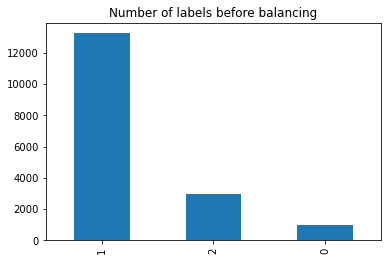

In [4]:
y.value_counts().plot(kind='bar', title='Number of labels before balancing')
plt.savefig("./plots/labels_before_balancing.png")

Resample dataset: Counter({1: 13241, 2: 13241, 0: 13241})


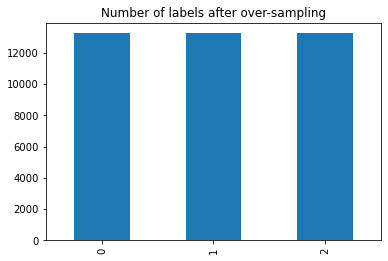

In [5]:
#1.3 balance dataset
#Reference: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
#under-sampling
"""
train_resample = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
cases_train, y = train_resample.fit_resample(cases_train, y)

print('Resample dataset shape', Counter(y))
y.value_counts().plot(kind='bar', title='Number of labels after under-sampling')
plt.savefig("./plots/labels_after_undersampling.png")
"""

#over-sampling
train_resample = RandomOverSampler(random_state=42)
cases_train, y = train_resample.fit_resample(cases_train, y)

print('Resample dataset:', Counter(y))
y.value_counts().plot(kind='bar', title='Number of labels after over-sampling')
plt.savefig("./plots/labels_after_oversampling.png")

In [6]:
#scale features in training dataset
#Reference: https://towardsdatascience.com/how-to-check-if-a-classification-model-is-overfitted-using-scikit-learn-148b6b19af8b
for column in cases_train.columns:
    feature = np.array(cases_train[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    cases_train[column] = feature_scaled.reshape(1,-1)[0]

In [7]:
#1.4 Building models and hyperparameter tuning
#split the dataset into 80% training set and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(cases_train, y, test_size = 0.2, random_state=123)

In [8]:
#build base random forest model
rf = RandomForestClassifier(random_state=7)

rf = rf.fit(X_train, y_train)
#Base Random Forest model Training Accuracy
y_pred = rf.predict(X_train) 
acc1 = accuracy_score(y_train, y_pred)
print("Base Random Forest model Training Accuracy: ", acc1)

Base Random Forest model Training Accuracy:  0.9370319088677701


In [9]:
#Base Random Forest model Testing Acuracy
y_pred = rf.predict(X_test)
acc2 = accuracy_score(y_test, y_pred)
print("Base Random Forest model Testing Acuracy: ", acc2)

Base Random Forest model Testing Acuracy:  0.9238514789175583


In [10]:
#hyperparameters passed to randomized search
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 115, 130]
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [2, 4, 5, 10,100, 1000]
min_samples_leaf = [1, 2, 4, 10, 100]

random_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [11]:
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,n_iter = 100,cv = 5,scoring='f1_macro',verbose=2,n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 10, 100],
                                        'min_samples_split': [2, 4, 5, 10, 100,
                                                              1000],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 115,
                                                         130]},
                   scoring='f1_macro', verbose=2)

In [12]:
#Best parameters returned by random search
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'gini'}

In [13]:
#hyperparameters passed to grid search
grid_param = {
    'n_estimators' : [40, 50, 60, 100, 115],
    'criterion': ['gini', 'entropy'],
    'max_features' : ['auto', 'log2', 'sqrt'],
    'max_depth' : [40, 50, 60, 70, 80, 90, None],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split': [2, 4]
}

In [14]:
rf_grid = GridSearchCV(estimator=rf,param_grid=grid_param,cv=5,scoring='f1_macro',n_jobs =-1,verbose = 3)
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 50, 60, 70, 80, 90, None],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [40, 50, 60, 100, 115]},
             scoring='f1_macro', verbose=3)

In [15]:
#Best parameters returned by random search
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 115}

In [16]:
#New Random Forest model with tuned hyperparameters
rf = RandomForestClassifier(criterion= 'entropy',
 max_depth = 40,
 max_features = 'auto',
 min_samples_leaf = 1,
 min_samples_split= 2,
 n_estimators = 115, random_state=7)

In [17]:
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=115,
                       random_state=7)

In [18]:
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Tuned Random Forest model Testing Acuracy: ", acc)

Tuned Random Forest model Testing Acuracy:  0.9244808055380742


In [19]:
#using k-fold to test the performance of Random Forest
kfold1 = model_selection.KFold(n_splits=5) 

#get mean macro F1-score and overall accuracy of all classes
scoring = {'accuracy' : make_scorer(accuracy_score),  
           'f1_score' : make_scorer(f1_score, average = 'macro')}

results = model_selection.cross_validate(estimator=rf,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold1,
                                          scoring=scoring)

print(sorted(results.keys()))

f1_mean = mean(results['test_f1_score'])
print("Mean macro F1-score : ", f1_mean)
acc_mean = mean(results['test_accuracy'])
print("Mean overall accuracy : ", acc_mean)

#get mean F1-score for 'deceased'
y_pred = cross_val_predict(rf, X_train, y_train, cv=kfold1)
report = classification_report(y_train, y_pred, target_names=['deceased', 'hospitalized', 'nonhospitalized'])
print(report)

['fit_time', 'score_time', 'test_accuracy', 'test_f1_score']
Mean macro F1-score :  0.9254420726429423
Mean overall accuracy :  0.9250425996190371
                 precision    recall  f1-score   support

       deceased       0.87      0.92      0.89     10552
   hospitalized       0.97      0.94      0.95     10628
nonhospitalized       0.95      0.91      0.93     10598

       accuracy                           0.93     31778
      macro avg       0.93      0.93      0.93     31778
   weighted avg       0.93      0.93      0.93     31778



In [20]:
#base XGbooster classifier
xgb1 = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
xgb1.fit(X_train,y_train)
print(xgb1.score(X_train,y_train))
print(xgb1.score(X_test,y_test))

0.9085845553527597
0.8956576463184392


In [21]:
#Reference: https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
param_random = {   'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,10,15,20]
             }


xgb_random = RandomizedSearchCV(estimator = xgb1, param_distributions = param_random, n_iter = 50, cv = 5, verbose=3, n_jobs = -1)
xgb_random.fit(X_train,y_train)

#best hyperparameters returned by random search
print('\n Best hyperparameters:')
print(xgb_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 20, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [22]:
# grid search in ten random param
param_grid = {   'min_child_weight': [1],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10,15,20]
             }

xgb_grid = GridSearchCV(estimator = xgb1, param_grid = param_grid, 
                                 cv = 3,verbose=2, n_jobs = -1, 
                                 scoring='f1_macro')
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constrain...
                                     objective='multi:softprob',
                                     predictor='auto', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos

In [23]:
#best hyperparameters returned by grid search
print('\n Best hyperparameters:')
print(xgb_grid.best_params_)


 Best hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8}


In [24]:
#tuned XGbooster classifier
best_xgb =  xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',
                        subsample= 0.8, min_child_weight= 6, 
                        max_depth= 20, gamma= 0.5, colsample_bytree= 0.8 )
best_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [25]:
print("Tuned XGbooster model Testing Acuracy: ", best_xgb.score(X_test,y_test))

Tuned XGbooster model Testing Acuracy:  0.9208307111390812


In [26]:
#using k-fold to test the performance of XGbooster
kfold2 = model_selection.KFold(n_splits=5) 

#get mean macro F1-score and overall accuracy of all classes
scoring = {'accuracy' : make_scorer(accuracy_score),  
           'f1_score' : make_scorer(f1_score, average = 'macro')}

results = model_selection.cross_validate(estimator=best_xgb,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold2,
                                          scoring=scoring)

print(sorted(results.keys()))

f1_mean = mean(results['test_f1_score'])
print("Mean macro F1-score : ", f1_mean)
acc_mean = mean(results['test_accuracy'])
print("Mean overall accuracy : ", acc_mean)

#get mean F1-score for 'deceased'
y_pred = cross_val_predict(best_xgb, X_train, y_train, cv=kfold2)
report = classification_report(y_train, y_pred, target_names=['deceased', 'hospitalized', 'nonhospitalized'])
print(report)

['fit_time', 'score_time', 'test_accuracy', 'test_f1_score']
Mean macro F1-score :  0.9183120063584627
Mean overall accuracy :  0.9179623037810597
                 precision    recall  f1-score   support

       deceased       0.86      0.91      0.88     10552
   hospitalized       0.96      0.94      0.95     10628
nonhospitalized       0.94      0.90      0.92     10598

       accuracy                           0.92     31778
      macro avg       0.92      0.92      0.92     31778
   weighted avg       0.92      0.92      0.92     31778



In [27]:
#base Gradient Boosting trees model
GBC = GradientBoostingClassifier()
GBC.fit(X_train,y_train)

#Base Random Forest model Training Accuracy
print(GBC.score(X_train,y_train))
#Base Random Forest model Testing Accuracy
print(GBC.score(X_test,y_test))

0.8208509031405374
0.8134675896790434


In [28]:
#hyperparameters passed to randomized search
grid = dict()
grid['n_estimators'] = [4, 32, 64, 100]
grid['learning_rate'] = [1, 0.5, 0.25, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [5, 10, 20, 40, 80]
grid['min_samples_split'] = [0.1, 0.5, 1.0 ,5,10,20, 40, 60, 100]
grid['min_samples_leaf'] = [0.1, 0.2, 0.3, 0.4, 0.5, 2, 5]
grid['max_features'] = ['auto', 'sqrt', 'log2']

cv = KFold(n_splits=3, shuffle=True)
random_search = RandomizedSearchCV(estimator = GBC, param_distributions = grid, n_iter = 100, 
                                 cv = cv, verbose=2, n_jobs = -1, 
                                 scoring='f1_macro')
    
random_search = random_search.fit(X_train, y_train)

random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'subsample': 1.0,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 80,
 'learning_rate': 1}

In [29]:
# train best random 
GBC = GradientBoostingClassifier(
 subsample= 0.7,
 n_estimators= 100,
 min_samples_split= 10,
 min_samples_leaf= 5,
 max_features= 2,
 max_depth= 40,
 learning_rate= 0.1)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=40, max_features=2, min_samples_leaf=5,
                           min_samples_split=10, subsample=0.7)

In [30]:
# grid search
grid = dict()
grid['n_estimators'] = [100,64,32]
grid['learning_rate'] = [0.25, 0.5, 0.1]
grid['subsample'] = [1.0,0.7]
grid['max_depth'] = [40, 20, 10, 80]
grid['min_samples_split'] = [20, 5, 10, 60]
grid['min_samples_leaf'] = [2, 5]
grid['max_features'] = ['sqrt', 'auto']

grid_search = GridSearchCV(estimator = GBC, param_grid = grid, 
                                 cv = 2, verbose=2, n_jobs = -1, 
                                 scoring='f1_macro')
#grid_search = grid_search.fit(X_train, y_train)

#grid_search.best_params_

In [31]:
# train the best grid
GBC = GradientBoostingClassifier(
 subsample= 0.7,
 n_estimators= 100,
 min_samples_split= 20,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 40,
 learning_rate= 0.1)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=40, max_features='auto',
                           min_samples_leaf=2, min_samples_split=20,
                           subsample=0.7)

In [32]:
print("Tuned Gradient Boosting trees model Testing Acuracy: ", GBC.score(X_test,y_test))

Tuned Gradient Boosting trees model Testing Acuracy:  0.9268722466960353


In [33]:
#using k-fold to test the performance of Gradient Boosting trees
kfold3 = model_selection.KFold(n_splits=5) 

#get mean macro F1-score and overall accuracy of all classes
scoring = {'accuracy' : make_scorer(accuracy_score),  
           'f1_score' : make_scorer(f1_score, average = 'macro')}

results = model_selection.cross_validate(estimator=GBC,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold3,
                                          scoring=scoring)

print(sorted(results.keys()))

f1_mean = mean(results['test_f1_score'])
print("Mean macro F1-score : ", f1_mean)
acc_mean = mean(results['test_accuracy'])
print("Mean overall accuracy : ", acc_mean)

#get mean F1-score for 'deceased'
y_pred = cross_val_predict(GBC, X_train, y_train, cv=kfold3)
report = classification_report(y_train, y_pred, target_names=['deceased', 'hospitalized', 'nonhospitalized'])
print(report)

['fit_time', 'score_time', 'test_accuracy', 'test_f1_score']
Mean macro F1-score :  0.9251974013491813
Mean overall accuracy :  0.9247593630283731
                 precision    recall  f1-score   support

       deceased       0.87      0.92      0.89     10552
   hospitalized       0.96      0.94      0.95     10628
nonhospitalized       0.95      0.91      0.93     10598

       accuracy                           0.92     31778
      macro avg       0.93      0.92      0.93     31778
   weighted avg       0.93      0.92      0.93     31778



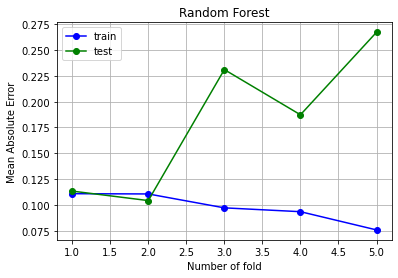

In [34]:
#1.5 check if the model is overfitted
#References: https://towardsdatascience.com/how-to-check-if-a-classification-model-is-overfitted-using-scikit-learn-148b6b19af8b
#check if random forest is overfitted
kf1 = KFold(n_splits=5)
mae_train = []
mae_test = []
for train_index, test_index in kf1.split(cases_train):
    
    X_train, X_test = cases_train.iloc[train_index], cases_train.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #random forest
    model = RandomForestClassifier(criterion= 'entropy',
             max_features = 'auto',
             max_depth = 40,
             min_samples_leaf = 1,
             min_samples_split= 2,
             n_estimators = 115, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))

folds = range(1, kf1.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='blue', label='train')
plt.plot(folds, mae_test, 'o-', color='green', label='test')
plt.legend()
plt.grid()
plt.title('Random Forest')
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.savefig("./plots/RF_overfit.png")
plt.show()

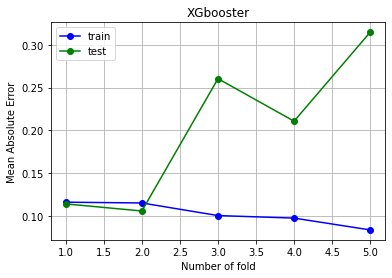

In [35]:
#check if XGbooster is overfitted
kf2 = KFold(n_splits=5)
mae_train = []
mae_test = []
for train_index, test_index in kf2.split(cases_train):
    
    X_train, X_test = cases_train.iloc[train_index], cases_train.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #XGbooster
    model = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',
                        subsample= 0.8, min_child_weight= 6, 
                        max_depth= 20, gamma= 0.5, colsample_bytree= 0.8)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))

folds = range(1, kf2.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='blue', label='train')
plt.plot(folds, mae_test, 'o-', color='green', label='test')
plt.legend()
plt.grid()
plt.title('XGbooster')
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.savefig("./plots/XGB_overfit.png")
plt.show()

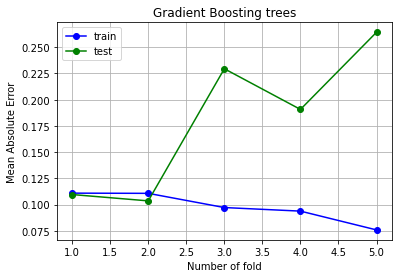

In [36]:
#check if Gradient Boosting trees is overfitted
kf3 = KFold(n_splits=5)
mae_train = []
mae_test = []
for train_index, test_index in kf3.split(cases_train):
    
    X_train, X_test = cases_train.iloc[train_index], cases_train.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Gradient Boosting trees
    model = GradientBoostingClassifier(
                 subsample= 0.7,
                 n_estimators= 100,
                 min_samples_split= 20,
                 min_samples_leaf= 2,
                 max_features= 'auto',
                 max_depth= 40,
                 learning_rate= 0.1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))

folds = range(1, kf3.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='blue', label='train')
plt.plot(folds, mae_test, 'o-', color='green', label='test')
plt.legend()
plt.grid()
plt.title('Gradient Boosting trees')
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.savefig("./plots/GBC_overfit.png")
plt.show()

In [37]:
cases_test = pd.read_excel('cases_2021_test_processed_unlabelled_2.xlsx')

features = ['age','sex','latitude','longitude','chronic_disease_binary','Confirmed','Deaths','Recovered','Active','Incident_Rate','Case_Fatality_Ratio']

cases_test = cases_test[features]

#sex column mapping
cases_test.sex = pd.Categorical(cases_test.sex)
cases_test['sex'] = cases_test.sex.cat.codes
#chronic_disease_binary column mapping
cases_test.chronic_disease_binary = pd.Categorical(cases_test.chronic_disease_binary)
cases_test['chronic_disease_binary'] = cases_test.chronic_disease_binary.cat.codes

In [38]:
#scale features in test dataset
for column in cases_test.columns:
    feature = np.array(cases_test[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    cases_test[column] = feature_scaled.reshape(1,-1)[0]

In [39]:
#use random forest to perdict
rf_outcome = rf.predict(cases_test)
print(rf_outcome, len(rf_outcome))

[2 1 1 ... 1 1 1] 4304


In [40]:
#use XGboster to perdict
xgb_outcome = best_xgb.predict(cases_test)
print(xgb_outcome, len(xgb_outcome))

[2 0 0 ... 0 1 1] 4304


In [41]:
#use Gradient Boosting trees to perdict
gbc_outcome = GBC.predict(cases_test)
print(gbc_outcome, len(gbc_outcome))

[2 1 0 ... 0 1 1] 4304


In [42]:
def create_submission_file(y_preds, file_name):
    with open(file_name, 'w') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])
create_submission_file(rf_outcome, 'submission_rf.csv')         
create_submission_file(rf_outcome, 'predictions.csv')
create_submission_file(xgb_outcome, 'submission_xgb.csv')
create_submission_file(gbc_outcome, 'submission_gbc.csv')
